# *Mounting Drive*

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# *Importing Required Libraries*

In [80]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import numpy as np
import os
from skimage.io import imread_collection
from PIL import Image
import math
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision.models import MobileNet_V2_Weights
import torch.nn as nn
import skimage.transform
import random
import time
import copy



# *Required Data Transforms*

In [81]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [82]:
data_dir = '/content/drive/MyDrive/assignment2_data/PascalVOC'
classes = 21 # No of classes are 21

# *Custom Dataset*

In [83]:
class SegmentationDataset(Dataset):
  
  # Init method

  def __init__(self, data_dir, mode, transform = None):
      self.mode = mode

      # Giving appropriate Image and mask directory for train data

      if mode == 'train':
        self.image_dir = os.path.join(data_dir, 'trainval/Images')
        self.mask_dir = os.path.join(data_dir, 'trainval')
        self.transform = transform
        self.masks = open(self.mask_dir + '/train.txt').readlines()
        self.mask_dir = os.path.join(data_dir, 'trainval/Annotations')

      # Giving appropriate Image and masks directory for val data

      elif mode == 'val':
        self.image_dir = os.path.join(data_dir, 'trainval/Images')
        self.mask_dir = os.path.join(data_dir, 'trainval')
        self.transform = transform
        self.masks = open(self.mask_dir + '/val.txt').readlines()
        self.mask_dir = os.path.join(data_dir, 'trainval/Annotations')
      
      # Giving approriate Image and masks directory for test data

      else:
        self.image_dir = os.path.join(data_dir, 'test/Images')
        self.mask_dir = os.path.join(data_dir, 'test/Annotations')
        self.transform = transform
        self.masks = os.listdir(self.mask_dir)
  
  # len method

  def __len__(self):
    return len(self.masks)
  
  # getiem method
  
  def __getitem__(self, index):
    if self.mode == 'test':
      mask_path = os.path.join(self.mask_dir, self.masks[index])
      img_path = os.path.join(self.image_dir, self.masks[index].replace('.png', '.jpg'))
    else:
      mask_path = os.path.join(self.mask_dir, self.masks[index].replace('\n', '.png'))
      img_path = os.path.join(self.image_dir, self.masks[index].replace('\n', '.jpg'))
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)
    new_tensor = transforms.PILToTensor()
    mask = new_tensor(mask)
    if self.transform is not None:
      image = self.transform(image)
      mask = transforms.Resize((224,224), interpolation=InterpolationMode.NEAREST)(mask)  
    return image, mask

# *Dataloaders*

In [84]:
image_datasets = {x: SegmentationDataset(data_dir, x, data_transforms) for x in ['train', 'val', 'test']}
 
# batch_size defined as per the usage in next cells

batch_size = {'train': 32, 'val': 32, 'test': 1}

# Train and Val data is shuffled and test data is not

shuffle = {'train': 'True', 'val': 'True', 'test': 'False'}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size[x], shuffle = shuffle[x], num_workers = 2) for x in ['train', 'val','test']}
dataset_sizes = {x :len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [85]:
def ReplaceValue(tensor, a, b):
    tensor[tensor == a] = b
    return tensor

In [86]:
print(dataset_sizes)

{'train': 209, 'val': 213, 'test': 210}


In [87]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [88]:
# Bilinear Kernal initializes the weights

def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    for i in range(out_channels):
        for j in range(in_channels):
            if i == j:
                weight[i, j, :, :] = filt
    return weight

# *Modifying MobileNetv2 model for Segmentation*

In [89]:
# Importing the MobileNetv2 model
class FCN_MobileNetv2(torch.nn.Module):
  def __init__(self, num_of_classes):
    super().__init__()
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights = MobileNet_V2_Weights.IMAGENET1K_V1)
    model = torch.nn.Sequential(*list(model.children())[:-1])
    for param in model.parameters():
      param.requires_grad = False
    self.block1 = nn.Sequential(
      nn.ConvTranspose2d(1280, 512, kernel_size = 4, stride = 2, padding = 1),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True)
      )
    self.block2 = nn.Sequential(
      nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True)
      )
    self.block3 = nn.Sequential(
      nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True)
      )
    self.block4 = nn.Sequential(
      nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True)
      )
    self.block5 = nn.Sequential(
      nn.ConvTranspose2d(64, 21, kernel_size = 4, stride = 2, padding = 1),
      nn.BatchNorm2d(21),
      nn.ReLU(inplace=True)
      ) 
    W1 = bilinear_kernel(1280, 512, 4)
    W2 = bilinear_kernel(512, 256, 4)
    W3 = bilinear_kernel(256, 128, 4)
    W4 = bilinear_kernel(128, 64, 4)
    W5 = bilinear_kernel(64, 21, 4)

    self.block1[0].weight.data.copy_(W1)
    self.block2[0].weight.data.copy_(W2)
    self.block3[0].weight.data.copy_(W3)
    self.block4[0].weight.data.copy_(W4)
    self.block5[0].weight.data.copy_(W5)
    
    self.model = model
  
  def forward(self, x):
    out = self.model(x)
    out = self.block1(out)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)
    return out

In [90]:
model = FCN_MobileNetv2(21)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


# *Summary of the Model after adding layers*

In [91]:
model = model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

# *Training the Model*

In [92]:
def train_model(model, scheduler, criterion, optimizer, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict)     ##state_dict - Python dicionary which maps each layer to its parameter tensor
  best_loss = np.inf
  model = model.to(device)

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
    
      running_loss = 0.00
      running_corrects = 0

      for inputs, masks in dataloaders[phase]:
        inputs = inputs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()   # zero the parameter gradients at the start of training loop
        

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          masks = masks.clone().squeeze().detach().long()
          outputs = outputs.type(torch.float64)

          loss = criterion(outputs, masks)
          
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
              

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / (len(dataloaders[phase].dataset)*224*224)

      print('{} Loss: {:.16f}'.format(phase, epoch_loss))

      if phase == 'val' and epoch_loss < best_loss:
          best_loss = epoch_loss
          best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  model.load_state_dict(best_model_wts)
  return model
  best_loss = np.inf

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
    
      running_loss = 0.00
      running_corrects = 0

      for inputs, masks in dataloaders[phase]:
        inputs = inputs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()   # zero the parameter gradients at the start of training loop
        

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          masks = masks.clone().squeeze().detach().long()
          outputs = outputs.type(torch.float64)

          loss = criterion(outputs, masks)
          
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
              

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / (len(dataloaders[phase].dataset)*224*224)

      print('{} Loss: {:.16f}'.format(phase, epoch_loss))

      if phase == 'val' and epoch_loss < best_loss:
          best_loss = epoch_loss
          best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  model.load_state_dict(best_model_wts)
  return model

In [93]:
params_to_update = []

# Training only the parameters that are newly added

for name,param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)

criterion = torch.nn.CrossEntropyLoss(ignore_index = 255)
optimizer = torch.optim.SGD(params_to_update, lr = 0.01, momentum = 0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 1)

In [94]:
# Training the model for 24 epochs

model = train_model(model, exp_lr_scheduler, criterion, optimizer)

Epoch 0/24
----------
train Loss: 0.0000734741679004
val Loss: 0.0000759685577327

Epoch 1/24
----------
train Loss: 0.0000623122807302
val Loss: 0.0000644780079940

Epoch 2/24
----------
train Loss: 0.0000564939392053
val Loss: 0.0000610850375609

Epoch 3/24
----------
train Loss: 0.0000544457178051
val Loss: 0.0000593610713732

Epoch 4/24
----------
train Loss: 0.0000527012386424
val Loss: 0.0000573204305059

Epoch 5/24
----------
train Loss: 0.0000505599115493
val Loss: 0.0000561103207519

Epoch 6/24
----------
train Loss: 0.0000474808640617
val Loss: 0.0000567479477733

Epoch 7/24
----------
train Loss: 0.0000412636339710
val Loss: 0.0000521429661949

Epoch 8/24
----------
train Loss: 0.0000373381457588
val Loss: 0.0000431024228141

Epoch 9/24
----------
train Loss: 0.0000336313326114
val Loss: 0.0000362291908374

Epoch 10/24
----------
train Loss: 0.0000301851292106
val Loss: 0.0000318543583376

Epoch 11/24
----------
train Loss: 0.0000273220676302
val Loss: 0.0000287889806328

Ep

# *Evaluation Mode*

In [95]:
# Outputs list will have the ouputs for all the test data
# Ground_truths list will have the given masks of all the test data

model.eval()
with torch.no_grad():
  outputs = []
  ground_truths = []
  with torch.no_grad():
    for inputs, masks in dataloaders['test']:
      inputs = inputs.to(device)
      outputs.append(torch.squeeze(model(inputs).argmax(1)).cpu().numpy())
      ground_truths.append(torch.squeeze(masks).numpy())

# *Pixel Wise Accuracy*

In [96]:
# Pixel wise accuracy Calculation
# for every image, we are calculating the no. of pixels matched / total pixels and averaging out on all the images

img_shape = outputs[0].shape
pixels_total = img_shape[0] * img_shape[1]
Accuracy_sum = 0
for i in range(dataset_sizes['test']):
  ground_truths[i] = ReplaceValue(ground_truths[i], 255, 0)
  outputs[i] = ReplaceValue(outputs[i], 255, 0)
  pixels_matched = np.sum(ground_truths[i] == outputs[i])
  Accuracy_sum += pixels_matched * 100 / pixels_total
print("Pixel wise Accuracy on Test Data is: " , Accuracy_sum / dataset_sizes['test'])

Pixel wise Accuracy on Test Data is:  77.15387550109331


# *MeanIOU Accuracy*

In [97]:
# MeanIOU calculation
# For every image, and for every class, we are calculating the MeanIOU and then averaging out on all classes and all images

Accuracy_list = []
for j in range(dataset_sizes['test']):
  Class_Accuracy_sum = 0
  for i in range(classes):
    class_arr = np.full(img_shape, i)
    mask_class = class_arr == ground_truths[j]
    output_class = class_arr == outputs[j]
    class_intersection = np.sum(np.logical_and(mask_class, output_class))
    class_union = np.sum(np.logical_or(mask_class, output_class))
    if class_union == 0:
      Class_Accuracy_sum += 100
    else:
      Class_Accuracy_sum += class_intersection * 100 / class_union
  Accuracy_list.append(Class_Accuracy_sum / classes)
print('MeanIOU Accuracy on Test Data is ', sum(Accuracy_list)/ len(Accuracy_list))

MeanIOU Accuracy on Test Data is  86.16131539517966


# *Visualization*

In [98]:
# Label Map

PALETTE = np.array(
    [
        [0, 0, 0],  # background
        [128, 0, 0], # aeroplane
        [0, 128, 0], # bicycle
        [128, 128, 0], # bird
        [0, 0, 128], # boat
        [128, 0, 128], # bottle
        [0, 128, 128],  # bus 
        [128, 128, 128], # car
        [64, 0, 0], # cat
        [192, 0, 0],  # chair
        [64, 128, 0], # cow
        [192, 128, 0], # dining table
        [64, 0, 128], # dog
        [192, 0, 128], # horse
        [64, 128, 128], # motorbike
        [192, 128, 128], # person
        [0, 64, 0], # potted plant
        [128, 64, 0], # sheep
        [0, 192, 0], # sofa
        [128, 192, 0], # train
        [0, 64, 128], # tv/monitor
    ]
    + [[0, 0, 0] for i in range(256 - 22)]
    + [[255, 255, 255]],
    dtype=np.uint8,
)

In [99]:
# Based on the class value of the pixel, AddPalette converts the image into 3 channel image with RGB values of appropriate class as per the PALETTE

def AddPalette(array):
    pil_out = Image.fromarray(array.astype(np.uint8), mode='P')
    pil_out.putpalette(PALETTE)
    return pil_out

In [100]:
# Visualize_model works in two modes
# If custom_image is given, then the model finds the output mask for it and visualizes it
# If custom_image is not given and the num_of_images is given, then the model visualizes-
# the ouputs masks and actual masks for the test data

def visualize_model(model, num_of_images = None, custom_image = None):
  
  model.eval()
  
  #inverse transform applied on the image that was preprocessed before

  invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
  
  # Test Data mode

  if num_of_images == None:
    with torch.no_grad():
      custom_image = data_transforms(custom_image)
      custom_image = torch.unsqueeze(custom_image, dim = 0)
      custom_image = custom_image.to(device, dtype = torch.float)
      custom_mask = torch.squeeze(model(custom_image).argmax(1)).cpu().numpy()
      custom_image = torch.squeeze(custom_image)
      custom_mask = AddPalette(custom_mask)
      custom_image = invTrans(custom_image)
      fig, axis = plt.subplots(ncols = 2, squeeze = False, figsize = (15,15))
      axis[0,0].imshow(custom_image.cpu().numpy().transpose(1,2,0))
      axis[0,1].imshow(custom_mask)
      axis[0,0].title.set_text('Original Image')
      axis[0,1].title.set_text('Ouput Annotation')
      plt.show()
      return

  # Custom_image mode
  
  with torch.no_grad():
    Image_index = random.sample(range(dataset_sizes['test']), num_of_images)
    for i in Image_index:
      image, mask = image_datasets['test'][i]
      image = torch.unsqueeze(image, dim = 0)
      image = image.to(device)
      output_mask = torch.squeeze(model(image).argmax(1)).cpu().numpy()
      image = torch.squeeze(image)
      mask = torch.squeeze(mask)
      mask = ReplaceValue(mask, 255, 0)
      mask = AddPalette(mask.numpy())
      output_mask = AddPalette(output_mask)
      
      image = invTrans(image)
      fig, axis = plt.subplots(ncols = 3, squeeze = False, figsize = (15,15))
      axis[0,0].imshow(image.cpu().numpy().transpose(1,2,0))
      axis[0,1].imshow(mask)
      axis[0,2].imshow(output_mask)
      axis[0,0].title.set_text('Original Image')
      axis[0,1].title.set_text('Actual Annotation')
      axis[0,2].title.set_text('Output Annotation')
      plt.show()
    return

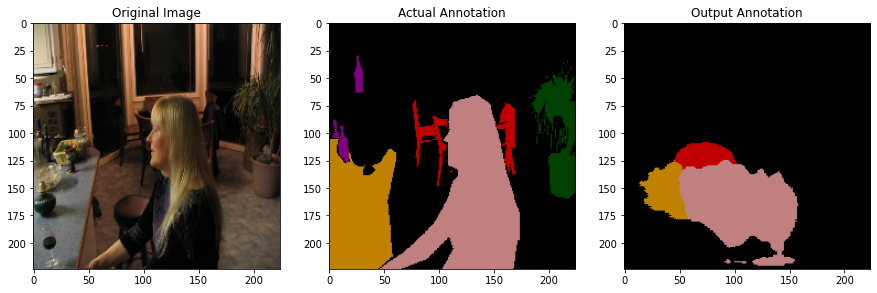

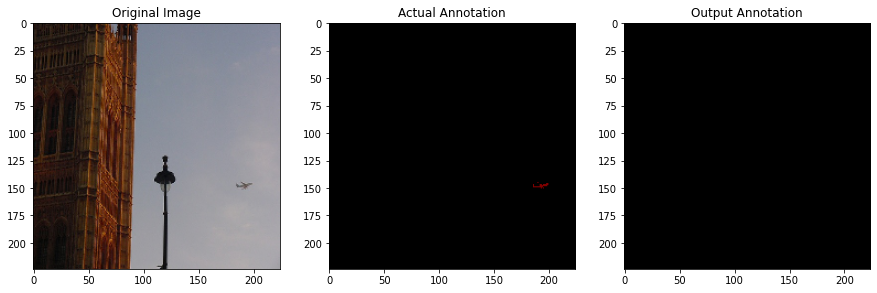

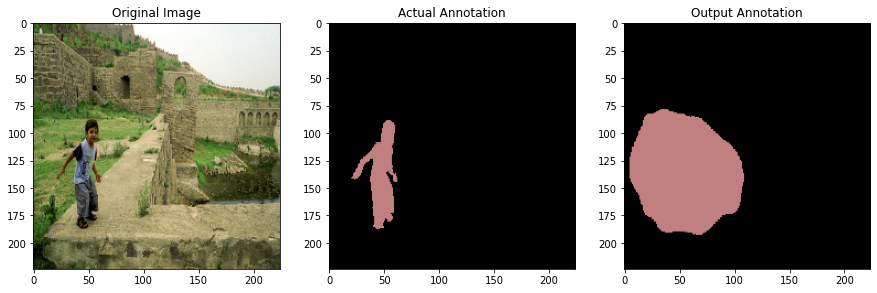

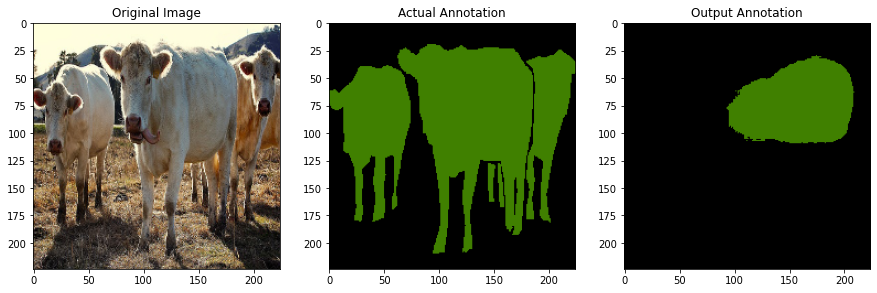

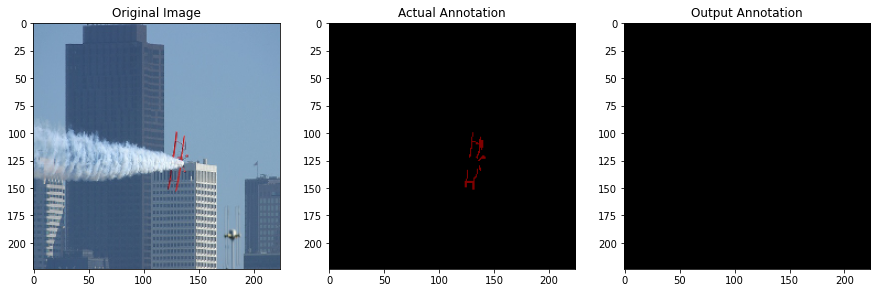

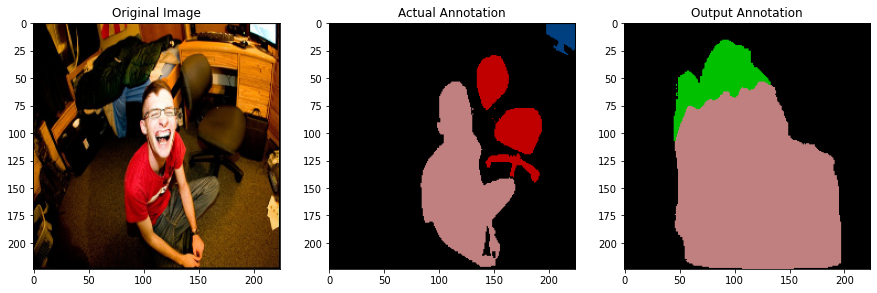

In [101]:
visualize_model(model, 6)

# *Modified MobileNetv2 on test_4 and test_5 Images of Ncut problem*

In [102]:
Ncut_data_dir = '/content/drive/MyDrive/assignment2_data/test_images'
load_pattern = os.path.join(Ncut_data_dir, '*jpg') + ':' + os.path.join(Ncut_data_dir, '*png')
test_images = imread_collection(load_pattern)

In [103]:
# test_4 and test_5 images are taken from Ncut Problem

eagle = test_images[3]
cycle = test_images[4]
eagle_rotated = skimage.transform.rotate(eagle, 45)
cycle_rotated = skimage.transform.rotate(cycle, 45)
eagle_noisy = skimage.util.random_noise(eagle, mode='gaussian')
cycle_noisy= skimage.util.random_noise(cycle, mode='gaussian')

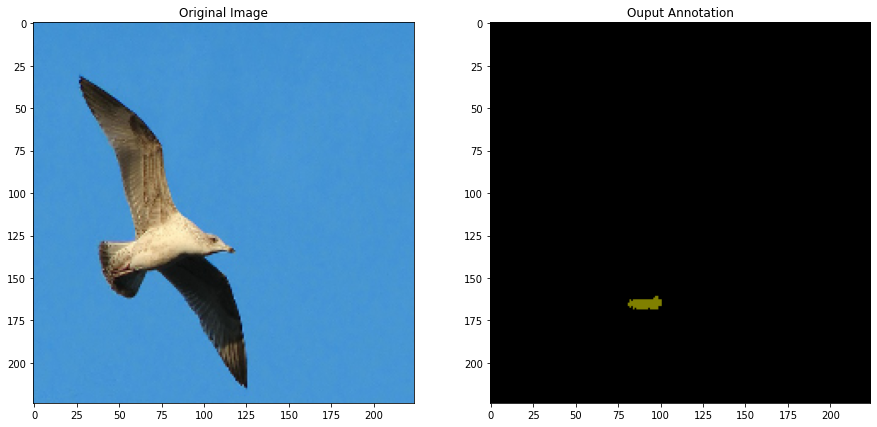

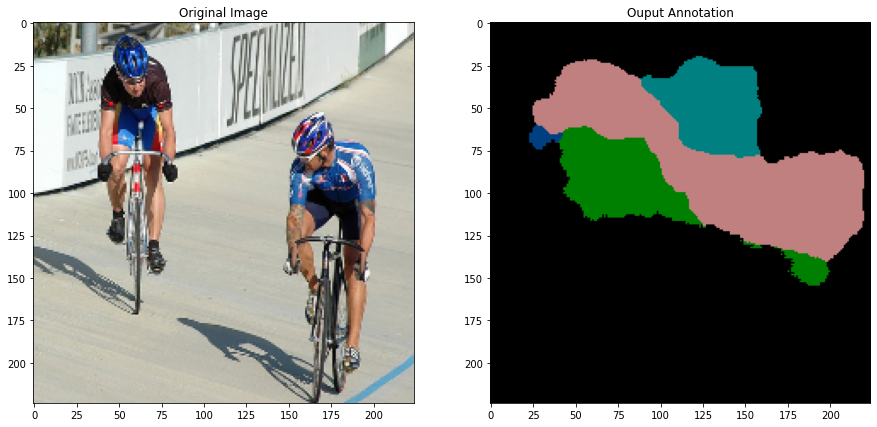

In [104]:
visualize_model(model, custom_image = eagle)
visualize_model(model, custom_image = cycle)

**Rotated Images**

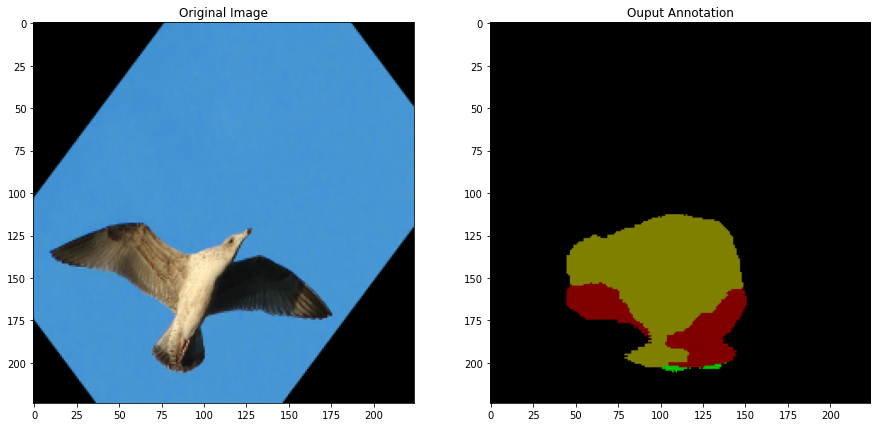

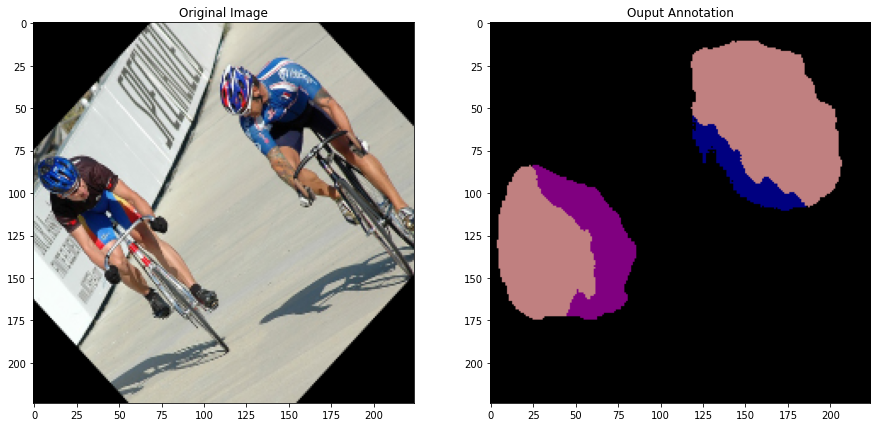

In [105]:
visualize_model(model, custom_image = eagle_rotated)
visualize_model(model, custom_image = cycle_rotated)

**Noisy Images**

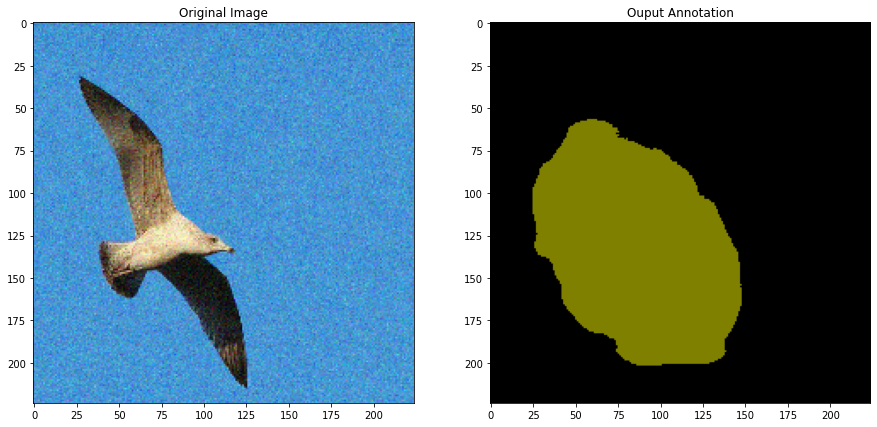

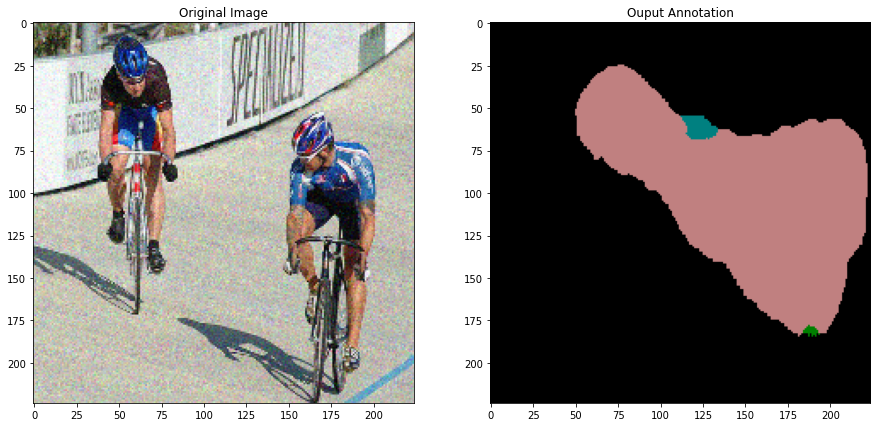

In [106]:
visualize_model(model, custom_image = eagle_noisy)
visualize_model(model, custom_image = cycle_noisy)